<a href="https://colab.research.google.com/github/djcordhose/buch-machine-learning-notebooks/blob/master/kap10/llms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLMS - OpenAI GPT API


* zum Ausführen ist ein OpenAI-Account notwendig: https://platform.openai.com/signup
* hier https://platform.openai.com/api-keys den eigenen Key erzeugen und eintragen 
* Kosten
  * https://openai.com/pricing
  * https://platform.openai.com/usage
* Installation und Quickstart: https://platform.openai.com/docs/quickstart?context=python  

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules # True if running in Google Colab.
IN_COLAB

False

In [2]:
if IN_COLAB:
    !pip install -q openai tiktoken

# Tokenizer

* Tokenizer zerlegen Texte in Zahlen 
* diese Zahlen korrespondieren mit Token
* Token könnten ganze Worte, Wortteile, Ziffern, Sonderzeichen oder Satzzeiten sein

https://github.com/openai/tiktoken

In [3]:
import tiktoken

# Dies ist der Tokenizer für GPT-4:
enc = tiktoken.encoding_for_model("gpt-4")
assert enc.decode(enc.encode("Hallo, Welt")) == "Hallo, Welt"
enc.encode("Hallo, Welt!0")

[79178, 11, 46066, 0, 15]

# OpenAI Client

In [4]:
# TODO: hier https://platform.openai.com/api-keys den eigenen Key erzeugen und eintragen
OPENAI_API_KEY = '...'
assert OPENAI_API_KEY != '...', "Bitte tragen Sie Ihren OpenAI API Key ein!"

In [5]:
from openai import OpenAI

client = OpenAI(
  api_key=OPENAI_API_KEY
)
models = client.models.list()

In [6]:
set([model.owned_by for model in models])

{'openai', 'openai-dev', 'openai-internal', 'system'}

In [7]:
set([model.id for model in models if model.owned_by == 'openai'])

{'ada',
 'babbage',
 'code-davinci-edit-001',
 'curie',
 'curie-instruct-beta',
 'davinci',
 'davinci-instruct-beta',
 'gpt-3.5-turbo',
 'gpt-3.5-turbo-0301',
 'gpt-3.5-turbo-0613',
 'gpt-3.5-turbo-16k-0613',
 'gpt-4',
 'gpt-4-0314',
 'gpt-4-0613',
 'text-ada-001',
 'text-babbage-001',
 'text-curie-001',
 'text-davinci-001',
 'text-davinci-002',
 'text-davinci-edit-001'}

In [8]:
completion = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "system", "content": "Du bist ein Experte im Bereich Machine Learning. Deine Antworten sind kurz und gut."},
    {"role": "user", "content": "Warum sind große Sprachmodelle so mächtig?"},
  ]
)
completion.choices[0].message.content

'Große Sprachmodelle sind mächtig, weil sie extrem viele Daten verarbeiten können und dadurch ein breites Verständnis von natürlicher Sprache entwickeln. Sie können komplexe Muster und Zusammenhänge erfassen und dadurch qualitativ hochwertige Texte generieren.'

# Embeddings

* https://openai.com/blog/introducing-text-and-code-embeddings
* https://platform.openai.com/docs/guides/embeddings
* https://platform.openai.com/docs/quickstart?context=python&lang=Embeddings
* https://platform.openai.com/docs/guides/embeddings/what-are-embeddings


In [9]:
[model.id for model in models if model.owned_by == 'openai-internal']

['gpt-3.5-turbo-16k',
 'text-davinci-003',
 'text-embedding-ada-002',
 'whisper-1',
 'tts-1']

In [10]:
import numpy as np

texts=[
    "Das Essen war toll und die Bedienung war super!",
    "Uns hat das Restaurant sehr gefallen, sowohl die Speisen als auch der Service!",
    "Was für ein übles Erlebnis, meine Nudeln waren viel zu weich und es hat ewig gedauert, bis wir unser bedient wurden.",
    "Hunde mögen gern Knochen."
]

response = client.embeddings.create(
  model="text-embedding-ada-002",
  input=texts
)

embeddings = np.array([embedding.embedding for embedding in response.data])
embeddings.shape

(4, 1536)

In [13]:
from sklearn.metrics.pairwise import cosine_similarity

cos_sim_matrix = cosine_similarity(embeddings)
cos_sim_matrix = np.round(cos_sim_matrix, 2)
cos_sim_matrix

array([[1.  , 0.93, 0.86, 0.77],
       [0.93, 1.  , 0.84, 0.77],
       [0.86, 0.84, 1.  , 0.76],
       [0.77, 0.77, 0.76, 1.  ]])

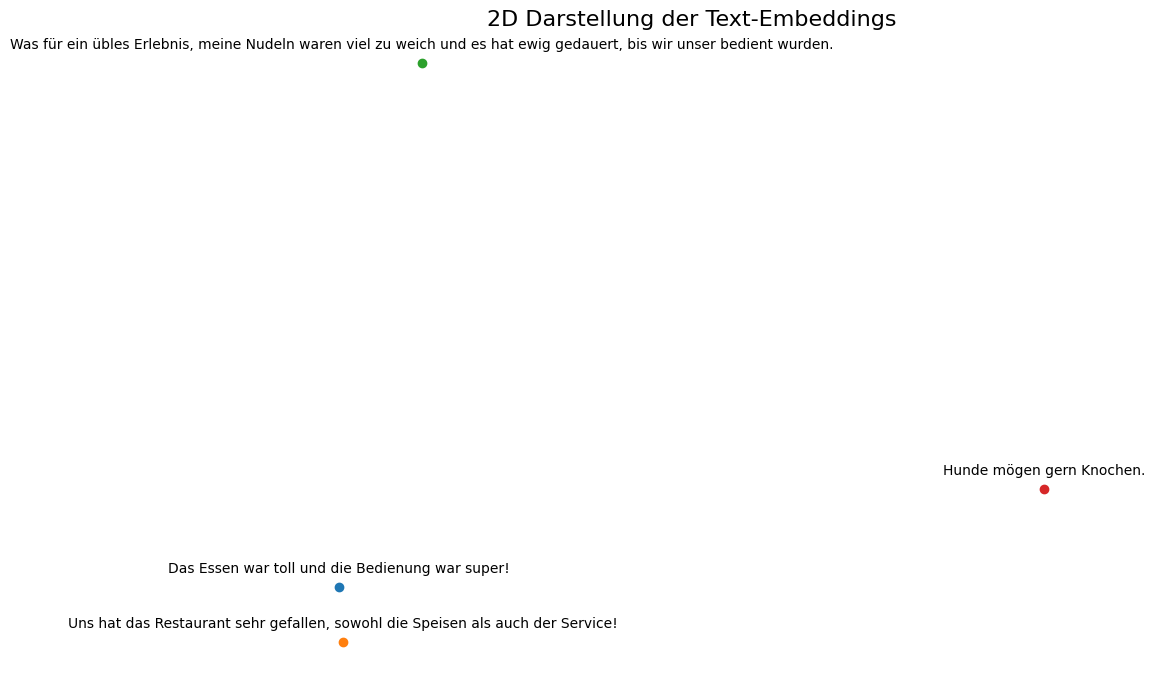

In [57]:
import matplotlib.pyplot as plt

# from sklearn.manifold import TSNE
# tsne = TSNE(n_components=2, random_state=42, perplexity=3)
# reduced_embeddings = tsne.fit_transform(embeddings)

# from umap import UMAP
# umap = UMAP(n_components=2, random_state=42, n_neighbors=3)
# reduced_embeddings = umap.fit_transform(embeddings)

from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
reduced_embeddings = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 6))
for i, label in enumerate(texts):
    x, y = reduced_embeddings[i, :]
    plt.scatter(x, y)
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.xticks([])
plt.yticks([])
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# plt.xlabel('1. Hauptkomponente')
# plt.ylabel('2. Hauptkomponente')

# add space between title and plot
plt.subplots_adjust(top=1.5)

plt.title('2D Darstellung der Text-Embeddings', fontsize=16)

# compress distance between points
plt.gca().set_aspect('equal', 'box')


plt.show();

# Prompt Engineering

Das hier ist das Ergebnis von https://platform.openai.com/playground/p/9Fsbs7sYgmiY4mFAHFeR1QX5?mode=chat

In [1]:
response = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {
      "role": "system",
      "content": "Bewerte den eingegebenen Text anhand der ausgedrückten Stimmung mit einem Wert zwischen 0 und 1. 0 für ein negatives Ergebnis, 1 für ein positives. \n\nBeispiele:\nUser: Ich weiß auch nicht so recht.\nAssistent: {'sentiment': 0.5 }\n\nUser: Das ist richtig toll.\nAssistent: {'sentiment': 1.0 }\n\nUser: Ganz schlimm.\nAssistent: {'sentiment': 0.0 }\n\nErzeuge ein JSON, das mit dem key \"sentiment\" und der Bewertung als value."
    },
    {
      "role": "user",
      "content": "Ich bin mit diesem Artikel zufrieden (von wegen)"
    },
    {
      "role": "assistant",
      "content": "{'sentiment': 0.0}"
    },
    {
      "role": "user"
    },
    {
      "role": "assistant",
      "content": "Ich bin mit diesem Artikel zufrieden"
    },
    {
      "role": "assistant",
      "content": "{'sentiment': 1.0}"
    },
    {
      "role": "user",
      "content": "Ich bin mit diesem Artikel zufrieden (zumindest anfänglich)"
    },
    {
      "role": "assistant",
      "content": "{'sentiment': 0.5}"
    }
  ],
  temperature=1,
  max_tokens=256,
  top_p=1,
  frequency_penalty=0,
  presence_penalty=0
)

OpenAIError: The api_key client option must be set either by passing api_key to the client or by setting the OPENAI_API_KEY environment variable